Model Workflow

# Data Loading &  Processing
## Data source: ccxt for real-time and historical data on OHLCV(open, high, low, closing & volume data) for digital currency (e.g. BTC) using a 1d (daily) timeframe 
Feature Engineering : calculate price, volume & volatility-based indicators 
- Price: Simple Moving Average(SMA), EMA, RSI, MACD (for momentum signals)
--> RSI: measure 
- Volume: OBV (On-Balance Volume), Money Flow Index (MFI)
- Volatility: ATR (Average True Range), Bollinger Bands Width(BBW)



# MODELS:
## 1. XGBoost with feature importances to select <10 features for feature selection 
run 6 xgboost models for close_n_ahead for n = 1 to ... as target variable, to exract predicted values(tnew) as input values for our loss function
- RandomSearch Optimization & 
- BayeasianSearch Optimization 
--> use 3 different optimization techniques: gp_minimize(mathematical), optuna & BayesSearchCV method 

## 2. ARIMA for Time Series - based forecasting
Further Feature engineering: implementing Time Series 
- Add weighted averages based on regression of lagged values, using partial autocorrelation (PACF) to identify autoregressive lags for feature selection
- Implement time-series modelling to forecast short-term price movements using ARIMA, & selecting best ARIMA model based on AIC/BIC criteria to obtain parameters (p - autoregressive order & q - simple moving average order)
Filling missing data with interpolation & normalization


backup model: 
## 3. Linear Regression with PCA for featue selection
- L1 Regularization & 
- L2 Regularization


## Trading Strategy ( based on research paper formula/loss function for calculating weights not provided v hard to obtain weights - suggest a new formula)

Calculate percentage returns and define a treshold to evaluate if price is expected to increase 
--> use log (% return) > x% or <= x% as evaluation criteria (compare against technical indicators?) to buy/sell
--> use own loss function and obtain the best alpha value which returns the best mse (btw tnew and toriginal)
loss function: tnew = w1t1 + w2t2 + ... + w6t6
- WEIGHTS w1, w2,..., w6:
1. Exponential increment
w1 = (1-alpha), w2 = (1-alpha)alpha,..., w6 = (1-alpah)alpha^5
2. Average 
w1 = w2 = ... = w6 = 1/6 alpha



Momentum Oscillators(BUY/SELL SIGNALS)
RSI: 
Purpose: Measures the speed & change of price movements.
Use Case: Buy if RSI < 30 (oversold), Sell if RSI > 70 (overbought)
MACD:
Purpose: Identifies trend reversals via moving average crossovers.
Use Case: Buy if MACD crosses above Signal Line, Sell if MACD crosses below Signal Line
(other indicators we have not considered)
Stochastic Oscillator(STOCH)
Purpose: Identifies overbought & oversold conditions based on recent highs/lows.
Use Case: Buy if %K crosses above %D in oversold zone (<20), Sell if %K crosses below %D in overbought zone (>80)
Rate of Change (ROC)
Purpose: Measures the percentage change of price over a given period.
Use Case: Buy when ROC turns positive, Sell when ROC turns negative.

Volitility Indicators 
Bollinger Bands:
Purpose: Measures price volatility relative to a moving average.
Use Case: Buy when price touches lower band, Sell when price touches upper band.
Average True Range (ATR)
Purpose: Measures market volatility by averaging true range values.
Use Case: High ATR → High volatility, Low ATR → Low volatility.

Volume Indicators 
On-Balance Volume (OBV)
Purpose: Cumulative volume indicator that tracks buying/selling pressure.
Use Case: Rising OBV suggests buying pressure, declining OBV suggests selling pressure.
Money Flow Index (MFI)
Purpose: Volume-weighted RSI to assess buying/selling pressure.
Use Case: Buy if MFI < 20, Sell if MFI > 80


Purpose of a virtual environment: 
Creating a specific location within the file to run/install packages that u need for use within a specific session instead of having them locally. 

In [425]:
#Data Loading
import ccxt
import pandas as pd
import time
from datetime import datetime, timedelta

# Initialize exchange
exchange = ccxt.binance()

# Define symbol and timeframe
symbol = 'BTC/USDT'
timeframe = '1d'

# Calculate timestamp for 1 year ago from Janauary as train data 
end_date = datetime(2025, 1, 1) 
start_date = end_date - timedelta(days=366)  

# Convert to milliseconds (Binance API uses Unix timestamp in milliseconds)
since = int(start_date.timestamp() * 1000)

# Fetch historical OHLCV data
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)

# Convert to DataFrame
data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

# Display the first few rows
print(data.head())
print(data.tail())  # Check the latest date to ensure correct range


   timestamp      open      high       low     close       volume
0 2024-01-01  42283.58  44184.10  42180.77  44179.55  27174.29903
1 2024-01-02  44179.55  45879.63  44148.34  44946.91  65146.40661
2 2024-01-03  44946.91  45500.00  40750.00  42845.23  81194.55173
3 2024-01-04  42845.23  44729.58  42613.77  44151.10  48038.06334
4 2024-01-05  44151.10  44357.46  42450.00  44145.11  48075.25327
     timestamp      open      high       low     close       volume
448 2025-03-24  86082.50  88765.43  85519.09  87498.16  30115.62111
449 2025-03-25  87498.16  88539.63  86310.00  87392.87  22643.25248
450 2025-03-26  87392.88  88275.00  85860.00  86909.17  18408.78485
451 2025-03-27  86909.17  87756.39  85800.00  87232.01  17098.03897
452 2025-03-28  87232.01  87515.67  84300.00  84442.66  16316.33705


In [427]:
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice, money_flow_index
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Calculate technical indicators
def calculate_technical_indicators(data):
    for n in [5,10,15]:
        data[f'SMA_{n}'] = SMAIndicator(data['close'], window = n).sma_indicator()
    data['EMA_9'] = EMAIndicator(data['close'], window=9).ema_indicator()
    data['RSI'] = RSIIndicator(data['close'], window=14).rsi()
    macd = MACD(data['close'], window_fast=12, window_slow=26, window_sign=9)
    data['MACD'] = macd.macd() 
    # data['MACD_signal'] = macd.macd_signal()
    # data['MACD_hist'] = macd.macd_diff()
    data['OBV'] = OnBalanceVolumeIndicator(data['close'], data['volume']).on_balance_volume()
    data['MFI_10'] = money_flow_index(data['high'], data['low'], data['close'], data['volume'], window=10)
    data['ATR_14'] = AverageTrueRange(data['high'], data['low'], data['close'], window=14).average_true_range()
    bands = BollingerBands(data['close'], window=20, window_dev = 2)
    data['upper_band'] = bands.bollinger_hband()
    # data['middle_band'] = bands.bollinger_mavg()
    data['lower_band'] = bands.bollinger_lband() 
    # data['BBW'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    data['daily_momentum'] = data['open'] - data['close']
    data['rolling_mean_3'] = data['close'].rolling(window=3).mean()
    data['rolling_std_3'] = data['close'].rolling(window=3).std()
    # Lagged Close prices
    data['close_lag_1'] = data['close'].shift(1)
    data['close_lag_2'] = data['close'].shift(2)
    #lead close prices
    for n in [1, 2, 5, 7, 10, 15, 20, 30]:
        data[f'close_{n}_ahead'] = data['close'].shift(-n)
    data['log_return'] = np.log(data['close']).diff()
    data['return_1'] =  (data['close_1_ahead'] - data['close']) / data['close']  
    
    return data 

#handle missing values
def handle_missing_data(data):
    data.ffill(inplace=True)
    data.bfill(inplace = True)
    return data 

btc_data = calculate_technical_indicators(data)
btc_data = handle_missing_data(btc_data)
# btc_data = normalize_data(btc_data)

#inspect data
print(btc_data.head()) 
print(btc_data.tail())


   timestamp      open      high       low     close       volume     SMA_5  \
0 2024-01-01  42283.58  44184.10  42180.77  44179.55  27174.29903  44053.58   
1 2024-01-02  44179.55  45879.63  44148.34  44946.91  65146.40661  44053.58   
2 2024-01-03  44946.91  45500.00  40750.00  42845.23  81194.55173  44053.58   
3 2024-01-04  42845.23  44729.58  42613.77  44151.10  48038.06334  44053.58   
4 2024-01-05  44151.10  44357.46  42450.00  44145.11  48075.25327  44053.58   

      SMA_10        SMA_15         EMA_9  ...  close_1_ahead  close_2_ahead  \
0  44788.027  44272.906667  44912.923399  ...       44946.91       42845.23   
1  44788.027  44272.906667  44912.923399  ...       42845.23       44151.10   
2  44788.027  44272.906667  44912.923399  ...       44151.10       44145.11   
3  44788.027  44272.906667  44912.923399  ...       44145.11       43968.32   
4  44788.027  44272.906667  44912.923399  ...       43968.32       43929.02   

   close_5_ahead  close_7_ahead  close_10_ahead  c

In [428]:
print(btc_data.columns)
print(btc_data.describe())
# check if there are any missing values
print(btc_data.isnull().sum())

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'SMA_5',
       'SMA_10', 'SMA_15', 'EMA_9', 'RSI', 'MACD', 'OBV', 'MFI_10', 'ATR_14',
       'upper_band', 'lower_band', 'daily_momentum', 'rolling_mean_3',
       'rolling_std_3', 'close_lag_1', 'close_lag_2', 'close_1_ahead',
       'close_2_ahead', 'close_5_ahead', 'close_7_ahead', 'close_10_ahead',
       'close_15_ahead', 'close_20_ahead', 'close_30_ahead', 'log_return',
       'return_1'],
      dtype='object')
                           timestamp           open           high  \
count                            453     453.000000     453.000000   
mean   2024-08-14 00:00:00.000000256   71214.323819   72686.311015   
min              2024-01-01 00:00:00   39568.020000   40176.740000   
25%              2024-04-23 00:00:00   60649.270000   61820.930000   
50%              2024-08-14 00:00:00   66784.680000   67939.400000   
75%              2024-12-05 00:00:00   87232.010000   88967.520000   
max              2025-03-2

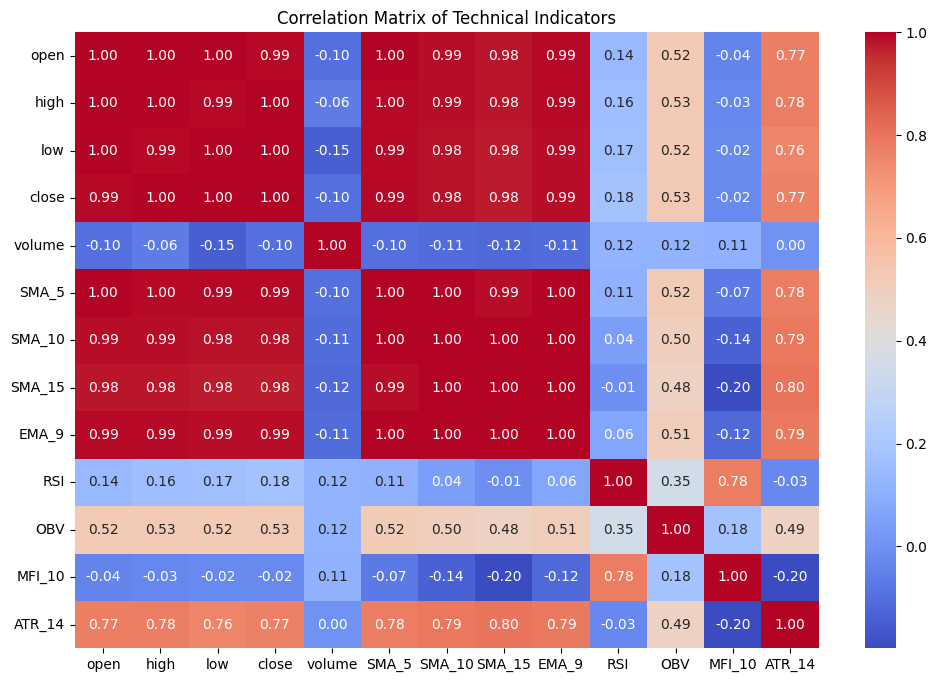

In [429]:
#EDA
import seaborn as sns
import matplotlib.pyplot as plt 

#Distribution of Each Indicaor 
indicators = ['open', 'high', 'low', 'close', 'volume', 'SMA_5','SMA_10', 'SMA_15', 'EMA_9', 'RSI', 'OBV', 'MFI_10', 'ATR_14']  # Select key indicators
def plot_eda():
    # plt.figure(figsize=(12, 6))
    # for i, indicator in enumerate(indicators):
    #     plt.subplot(2, 4, i + 1)
    #     sns.histplot(data[indicator], kde=True, bins=30)
    #     plt.title(indicator)
    # plt.tight_layout()
    # plt.show()

    #Check for Correlations(Feature Redundancy)
    #Some indicators might be highly correlated, making them redundant
    #If correlation > 0.85, remove one of the correlated features.
    # Example: SMA and EMA are usually correlated → Keep only one.
    plt.figure(figsize=(12, 8))
    sns.heatmap(data[indicators].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Technical Indicators")
    plt.show()

    # #Comparing Indicators with closing prices (Plot Trends Over Time)
    # # Check how SMA and EMA interact with price.
    # # Identify points where indicators signal trend reversals.

    # plt.figure(figsize=(12, 6))
    # plt.plot(data.index, data['close'], label='Close Price', color='black')
    # plt.plot(data.index, data['SMA'], label='SMA', linestyle='dashed', color='blue')
    # plt.plot(data.index, data['EMA'], label='EMA', linestyle='dashed', color='red')
    # plt.legend()
    # plt.title("Price with SMA and EMA")
    # plt.show()

    # #Identify Overbought & Oversold Conditions (RSI & MACS)
    # # A. RSI (Relative Strength Index)
    # # RSI > 70 → Overbought (possible sell signal)
    # # RSI < 30 → Oversold (possible buy signal)
    # # Are most RSI values in a normal range (30-70)?
    # # Do RSI peaks align with price reversals?
    # plt.figure(figsize=(12, 6))
    # plt.plot(data.index, data['RSI'], label="RSI", color="purple")
    # plt.axhline(70, linestyle="dashed", color="red", label="Overbought")
    # plt.axhline(30, linestyle="dashed", color="green", label="Oversold")
    # plt.legend()
    # plt.title("RSI Indicator")
    # plt.show()

    # # B. MACD (Moving Average Convergence Divergence)
    # # MACD > Signal Line → Bullish
    # # MACD < Signal Line → Bearish
    # plt.figure(figsize=(12, 6))
    # plt.plot(data.index, data['MACD'], label='MACD', color='blue')
    # plt.plot(data.index, data['MACD_signal'], label='Signal Line', color='red')
    # plt.axhline(0, linestyle="dashed", color="black")
    # plt.legend()
    # plt.title("MACD Indicator")
    # plt.show()

plot_eda()


# XGBoost

In [430]:
print(btc_data.columns)

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'SMA_5',
       'SMA_10', 'SMA_15', 'EMA_9', 'RSI', 'MACD', 'OBV', 'MFI_10', 'ATR_14',
       'upper_band', 'lower_band', 'daily_momentum', 'rolling_mean_3',
       'rolling_std_3', 'close_lag_1', 'close_lag_2', 'close_1_ahead',
       'close_2_ahead', 'close_5_ahead', 'close_7_ahead', 'close_10_ahead',
       'close_15_ahead', 'close_20_ahead', 'close_30_ahead', 'log_return',
       'return_1'],
      dtype='object')


In [ ]:
data = btc_data
# Features and target
features = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'SMA_5',
       'SMA_10', 'SMA_15', 'EMA_9', 'RSI', 'MACD', 'OBV', 'MFI_10', 'ATR_14',
       'upper_band', 'lower_band', 'daily_momentum', 'rolling_mean_3',
       'rolling_std_3', 'close_lag_1', 'close_lag_2']
targets = ['close_1_ahead', 'close_2_ahead', 'close_5_ahead', 'close_7_ahead', 'close_10_ahead', 'close_15_ahead', 'close_20_ahead', 'close_30_ahead', 'return_1']

#define date range correctly
train_end_date = pd.to_datetime('2025-01-01') 
val_end_date = pd.to_datetime('2025-02-28')
test_end_date = pd.to_datetime('2025-03-01')

# Split the data
train_data = data[data['timestamp'] < train_end_date]
val_data = data[(data['timestamp'] >= train_end_date) & (data['timestamp'] <= val_end_date)]
test_data = data[(data['timestamp'] >= val_end_date)]



# Split into X & y 
X_train = train_data[features]
X_val = val_data[features]
X_test = test_data[features]


y_train = train_data[targets]
y_val = val_data[targets]
y_test = test_data[targets]

print(f"X_train size: {X_train.shape}")
print(f"X_val size: {X_val.shape}")
print(f"X_test size: {X_test.shape}")
print(f"y_train size: {y_train.shape}")
print(f"y_val size: {y_val.shape}")
print(f"y_test size: {y_test.shape}")

print(f"Train data: {train_data['timestamp'].min()} to {train_data['timestamp'].max()}")
print(f"Train data: {val_data['timestamp'].min()} to {val_data['timestamp'].max()}")
print(f"Test data: {test_data['timestamp'].min()} to {test_data['timestamp'].max()}")

X_train size: (366, 23)
X_val size: (59, 23)
X_test size: (29, 23)
y_train size: (366, 9)
y_val size: (59, 9)
y_test size: (29, 9)
Train data: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Train data: 2025-01-01 00:00:00 to 2025-02-28 00:00:00
Test data: 2025-02-28 00:00:00 to 2025-03-28 00:00:00


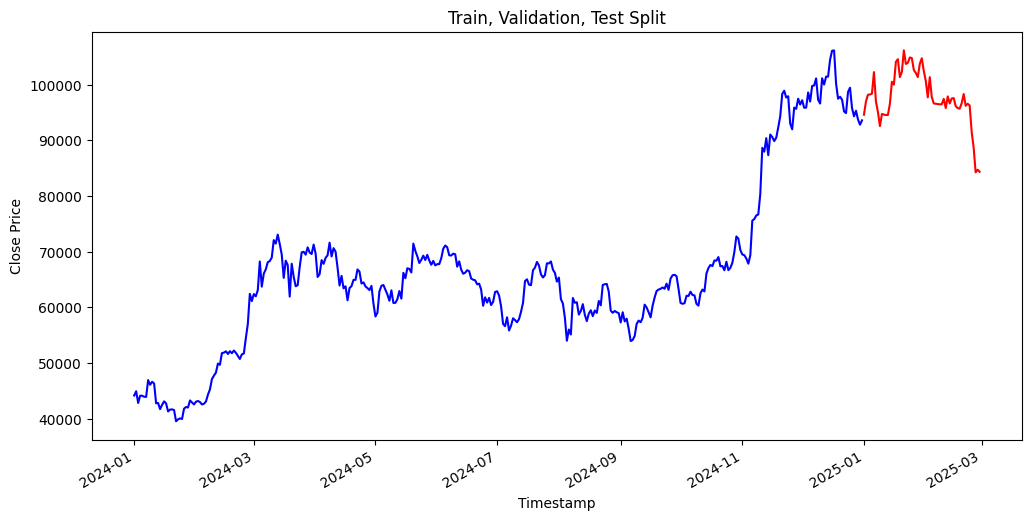

In [431]:
def visualize_train_test_split():
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['timestamp'], train_data['close'], label='Train', color='blue')
    plt.plot(val_data['timestamp'], val_data['close'], label='Validation', color='red')
    plt.title("Train, Validation, Test Split")
    plt.xlabel('Timestamp')
    plt.ylabel('Close Price')
    plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
    plt.show()
visualize_train_test_split()

In [35]:
# Plot BTC price development candlestick chart
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=data['timestamp'], open=data['open'], high=data['high'], low=data['low'], close=data['close'])])
fig.update_layout(title='BTC/USDT Price Development', xaxis_title='Date', yaxis_title='Price')
#theme minimal
fig.update_layout(template='simple_white')
fig.show()


### Hyperparameter Tuning

In [ ]:
#all libraries
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, TimeSeriesSplit, PredefinedSplit, GridSearchCV, cross_val_score, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.feature_selection import VarianceThreshold
from skopt import BayesSearchCV, gp_minimize
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.space import Real, Integer
import numpy as np
import matplotlib.pyplot as plt
import optuna


Random Search CV

Running Rolling Expanding Validation...
Best Hyperparameters from Rolling Validation: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}

Running Final Hyperparameter Tuning on X_train → X_val...

Best Hyperparameters from PredefinedSplit: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}


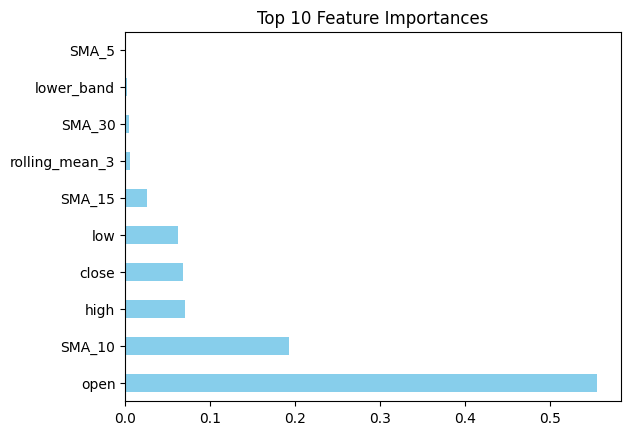

Selected Features based on Importance: Index(['open', 'SMA_10', 'high', 'close', 'low', 'SMA_15', 'rolling_mean_3',
       'SMA_30', 'lower_band', 'SMA_5'],
      dtype='object')

=== Train Performance (Jan-Dec 2024) ===
MSE: 1080923.6596
MAE: 779.9740
R²: 0.9950

=== Validation Performance (Jan-Feb 2025) ===
MSE: 924274.5443
MAE: 737.6819
R²: 0.9630

=== Test Performance (March-April 2025) ===
MSE: 10982041.2789
MAE: 2481.1900
R²: -0.1514


In [465]:
def random_search(target_var):
    # Combine train + val for final training later
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train[target_var], y_val[target_var]])

    # Perform Rolling Expanding Validation  
    tscv = TimeSeriesSplit(n_splits=10)  
    model = XGBRegressor(random_state=42)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05],
        'max_depth': [3, 5],
        'min_child_weight': [5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0.1, 1.0],
        'reg_lambda': [1.0, 2.0],
    }

    # Perform Random Search with TimeSeriesSplit cross-validation
    random_search = RandomizedSearchCV(
        model, 
        param_grid, 
        n_iter=50, 
        cv=tscv,  
        n_jobs=4,
        random_state=42,
        scoring='neg_mean_squared_error'
    )

    print("Running Rolling Expanding Validation...")
    random_search.fit(X_train, y_train[target_var])  

    # Hyperparameter Tuning using PredefinedSplit (X_train → X_val) ---
    best_params = random_search.best_params_

    print("Best Hyperparameters from Rolling Validation:", best_params)

    model = XGBRegressor(**best_params, random_state=42)
    
    # Create custom validation split: -1 for train, 0 for validation
    split_index = [-1] * len(X_train) + [0] * len(X_val)
    ps = PredefinedSplit(test_fold=split_index)

    random_search_ps = RandomizedSearchCV(
        model,
        param_grid,
        n_iter=50,
        cv=ps,
        n_jobs=4,
        random_state=42,
        scoring='neg_mean_squared_error'
    )
    
    print("\nRunning Final Hyperparameter Tuning on X_train → X_val...")
    random_search_ps.fit(X_train_val, y_train_val)

    best_params = random_search_ps.best_params_
    print("\nBest Hyperparameters from PredefinedSplit:", best_params)

    # Evaluate Feature Importance for Feature Selection
    best_model = XGBRegressor(**best_params, random_state=42)
    best_model.fit(X_train_val, y_train_val)  # Train on full pre-test data to evaluate feature importance

    # Extract feature importances
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train_val.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)

    # Plot Feature Importance
    feature_importances_sorted[:10].plot(kind='barh', color='skyblue')
    plt.title("Top 10 Feature Importances")
    plt.show()

    # Select features based on importance (e.g., those with importance > 0.05)
    selected_features = feature_importances_sorted.head(10).index
    print("Selected Features based on Importance:", selected_features)

    # Train Final Model with Only Selected Features 
    X_train_selected = X_train[selected_features]
    X_val_selected = X_val[selected_features]
    X_train_val_selected = X_train_val[selected_features]
    X_test_selected = X_test[selected_features]

    final_model = XGBRegressor(**best_params, random_state=42)
    final_model.fit(X_train_val_selected, y_train_val)  # Train on selected features

    # Evaluate on Train & Validation
    y_train_pred = final_model.predict(X_train_selected)
    y_val_pred = final_model.predict(X_val_selected)

    print("\n=== Train Performance (Jan-Dec 2024) ===")
    print(f"MSE: {mean_squared_error(y_train[target_var], y_train_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_train[target_var], y_train_pred):.4f}")
    print(f"R²: {r2_score(y_train[target_var], y_train_pred):.4f}")

    print("\n=== Validation Performance (Jan-Feb 2025) ===")
    print(f"MSE: {mean_squared_error(y_val[target_var], y_val_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_val[target_var], y_val_pred):.4f}")
    print(f"R²: {r2_score(y_val[target_var], y_val_pred):.4f}")

    # Evaluate on Test Data (March–April 2025) 
    y_test_pred = final_model.predict(X_test_selected)

    print("\n=== Test Performance (March-April 2025) ===")
    print(f"MSE: {mean_squared_error(y_test[target_var], y_test_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test[target_var], y_test_pred):.4f}")
    print(f"R²: {r2_score(y_test[target_var], y_test_pred):.4f}")

    return y_train_pred, y_val_pred, y_test_pred

# Run
train_predictions_rs, val_predictions_rs, test_predictions_rs = random_search('close_1_ahead')


In [435]:
def plot_actual_vs_predicted(train_preds, val_preds, test_preds, 
                           y_train, y_val, y_test, target_var):

    plt.figure(figsize=(20, 10))
    
    # Plot Training Set
    plt.plot(train_data['timestamp'], y_train[target_var], 
             label='Actual (Train)', color='blue', linewidth=2)
    plt.plot(train_data['timestamp'], train_preds, 'g--', 
             label='Predicted (Train)', linewidth=2)
    
    # Plot Validation Set
    plt.plot(val_data['timestamp'], y_val[target_var], 
             label='Actual (Validation)', color='orange', linewidth=2)
    plt.plot(val_data['timestamp'], val_preds, 'y--', 
             label='Predicted (Validation)', linewidth=2)
    
    # Plot Test Set
    plt.plot(test_data['timestamp'], y_test[target_var], 
             label='Actual (Test)', color='red', linewidth=2)
    plt.plot(test_data['timestamp'], test_preds, 'm--', 
             label='Predicted (Test)', linewidth=2)
    
    # Add vertical dividers between periods
    last_train_date = train_end_date
    last_val_date = val_end_date
    
    plt.axvline(x=last_train_date, color='k', linestyle=':', alpha=0.5)
    plt.axvline(x=last_val_date, color='k', linestyle=':', alpha=0.5)
    
    # Formatting
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.title('Actual vs Predicted Prices', fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()



def residual_plot(val_pred, test_pred):
    val_residuals = y_train[targets[0]] - val_pred
    test_residuals = test_data[targets[0]] - test_pred
    # Plot residuals for validation set
    plt.figure(figsize=(12, 6))
    plt.scatter(val_pred, val_residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residual Plot (Validation Set)")
    plt.xlabel("Predicted Prices")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.show()

    # Plot residuals for test set
    plt.figure(figsize=(12, 6))
    plt.scatter(test_pred, test_residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residual Plot (Test Set)")
    plt.xlabel("Predicted Prices")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.show()
#residual_plot()

# def mse_plot(train_mse, test_mse)
    


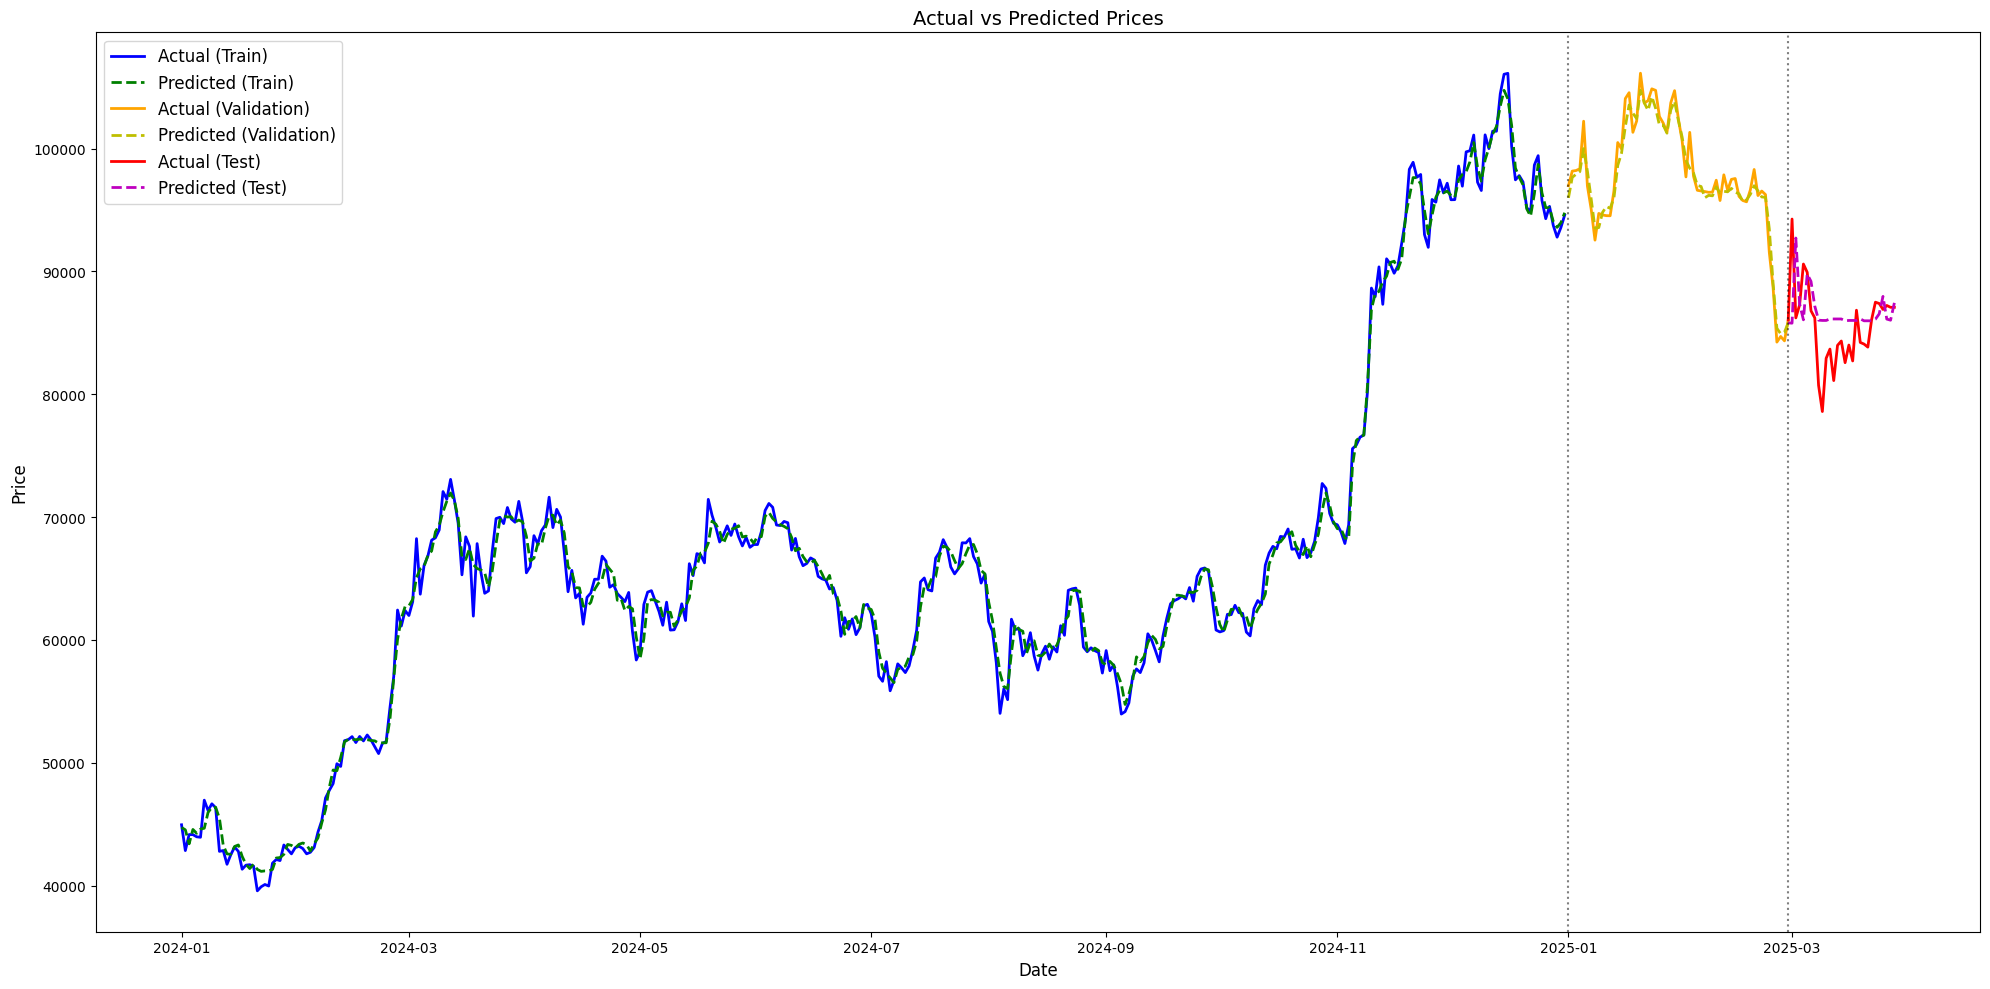

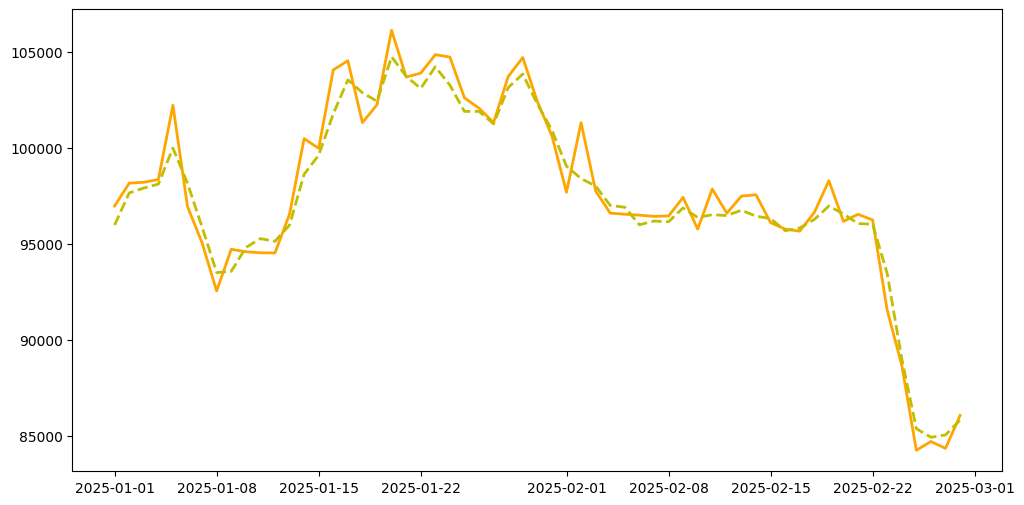

In [466]:
plot_actual_vs_predicted(
    train_predictions_rs,
    val_predictions_rs,
    test_predictions_rs,
    y_train,
    y_val,
    y_test, 
    'close_1_ahead'
)

# Plot Validation Set
plt.figure(figsize=(12,6))
plt.plot(val_data['timestamp'], y_val['close_1_ahead'], 
            label='Actual (Validation)', color='orange', linewidth=2)
plt.plot(val_data['timestamp'], val_predictions_rs, 'y--', 
            label='Predicted (Validation)', linewidth=2)
plt.show()
    

Bayesian Optimization

In [398]:

def bayes_xg_boost(target_var):
    # Define the model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=50, random_state=42)

    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train[target_var], y_val[target_var]])

    tscv = TimeSeriesSplit(n_splits = 5)

    split_index = [-1] * len(X_train) + [0] * len(X_val)
    ps = PredefinedSplit(test_fold=split_index)

    # Define the search space for hyperparameters 
    search_space = [
        Real(0.01, 0.7, name='learning_rate', prior='log-uniform'),
        Integer(5, 14, name='max_depth'),
        Real(0, 1.6, name='gamma'),
        Real(0.4, 6.4, name='alpha'),
        Real(0.4, 6.4, name='lambda_'),
        Integer(50,200, name='n_estimators')
    ]


    # Define the objective function for gp_minimize
    @use_named_args(search_space)
    def objective(learning_rate, max_depth, gamma, alpha, lambda_, n_estimators):
        # Set the model parameters
        model.set_params(
            learning_rate=learning_rate,
            max_depth=max_depth,
            gamma=gamma,
            alpha=alpha,
            lambda_=lambda_, 
            n_estimators = n_estimators
        )
        scores = cross_val_score(model, X_train, train_data[target_var], 
                                cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
        
        return -np.mean(scores) 

    # Step 1: Optimize the mathematical function using gp_minimize
    result = gp_minimize(
        func=objective,
        dimensions=search_space,
        n_calls=30,
        n_initial_points=10,
        acq_func="EI",
        random_state=42
    )

    # Best parameters from gp_minimize
    best_params_gp = {
        'learning_rate': result.x[0],
        'max_depth': int(result.x[1]),
        'gamma': result.x[2],
        'alpha': result.x[3],
        'lambda': result.x[4]

    }
    

    #evaluate gp_minimize parameters
    model_gp = XGBRegressor(**best_params_gp, objective='reg:squarederror', random_state=42)
    model_gp.fit(X_train, y_train[target_var])
    val_prediction_gp = model_gp.predict(X_val)
    mse_gp = mean_squared_error(y_val[target_var], val_prediction_gp)
    print(f"Prediction MSE (gp_minimize): {mse_gp}")


    # Step 2: Optimize hyperparameters using BayesSearchCV
    opt = BayesSearchCV(
        model,
        {param.name: param for param in search_space},
        cv=tscv,
        n_jobs=-1,
        scoring='neg_mean_squared_error',
        random_state=42
    )

    opt.fit(X_train, y_train[target_var])

    # Best parameters from BayesSearchCV
    best_params_bayescv = opt.best_params_
    test_prediction_bayescv = opt.predict(X_val)
    mse_bayescv = mean_squared_error(y_val[target_var], test_prediction_bayescv)
    print(f"Prediction MSE (BayesSearchCV): {mse_bayescv}")

    def objective_optuna(trial):
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 5, 7),
            'gamma': trial.suggest_float('gamma', 0, 1.6),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.4, 6.4),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.4, 6.4), 
            'n_estimators': trial.suggest_int('n_estimators', 50, 200)
        }
        model = XGBRegressor(**params, objective='reg:squarederror', random_state=42)
        scores = cross_val_score(model, X_train, y_train[target_var], 
                                cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        return -np.mean(scores)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective_optuna, n_trials=25)

    best_params_optuna = study.best_params
    model_optuna = XGBRegressor(**best_params_optuna, objective='reg:squarederror', random_state=42)
    model_optuna.fit(X_train, y_train[target_var])
    test_prediction_optuna = model_optuna.predict(X_val)
    mse_optuna = mean_squared_error(y_val[target_var], test_prediction_optuna)
    print(f"Prediction MSE (Optuna): {mse_optuna}")

    # Step 4: Compare results and select the best parameters
    results = {
        'gp_minimize': {'params': best_params_gp, 'mse': mse_gp},
        'BayesSearchCV': {'params': best_params_bayescv, 'mse': mse_bayescv},
        'Optuna': {'params': best_params_optuna, 'mse': mse_optuna}
    }

    best_method = min(results, key=lambda k: results[k]['mse'])
    best_params_final = results[best_method]['params']
    print(f"Best method: {best_method}")
    print(f"Best parameters: {best_params_final}")

    # Step 5: Train the final model with the best parameters
    final_model = XGBRegressor(**best_params_final, objective='reg:squarederror', random_state=42)
    final_model.fit(X_train, y_train[target_var])


    #Compare model with train set
    train_prediction_bayes = final_model.predict(X_train)
    train_mse = mean_squared_error(y_train[target_var], train_prediction_bayes)
    print(f"Train MSE: {train_mse}")

    val_prediction_bayes = final_model.predict(X_val)
    val_mse = mean_squared_error(y_val[target_var], val_prediction_bayes)
    print(f"Validation MSE: {val_mse}")

    # Evaluate the final model on the test set
    test_prediction_bayes = final_model.predict(X_test)
    test_mse = mean_squared_error(y_test[target_var], test_prediction_bayes)
    print(f"Test MSE (Final Model): {test_mse}")

    return  final_model, best_params_final, train_prediction_bayes, val_prediction_bayes, test_prediction_bayes 

In [400]:
bayes_xg_boost_1_model, bayes_xg_boost_1_params, train_prediction_bayes, val_prediction_bayes, test_prediction_bayes = bayes_xg_boost('close_1_ahead')

Prediction MSE (gp_minimize): 12355814.234336467


[I 2025-03-28 17:42:33,866] A new study created in memory with name: no-name-d37de8f7-fc95-4ed0-8b5e-6b8b16a5f877


Prediction MSE (BayesSearchCV): 10971511.293719746


[I 2025-03-28 17:42:34,749] Trial 0 finished with value: 207142174.83121338 and parameters: {'learning_rate': 0.05289736690496847, 'max_depth': 6, 'gamma': 1.476302290850536, 'reg_alpha': 4.084942942580415, 'reg_lambda': 6.006396912474854, 'n_estimators': 109}. Best is trial 0 with value: 207142174.83121338.
[I 2025-03-28 17:42:35,229] Trial 1 finished with value: 197773556.77299812 and parameters: {'learning_rate': 0.0846728401635072, 'max_depth': 6, 'gamma': 1.158269001638411, 'reg_alpha': 5.494160139036233, 'reg_lambda': 6.068736335356164, 'n_estimators': 71}. Best is trial 1 with value: 197773556.77299812.
[I 2025-03-28 17:42:35,669] Trial 2 finished with value: 203009168.36732697 and parameters: {'learning_rate': 0.07229373022956943, 'max_depth': 6, 'gamma': 0.8187240368226762, 'reg_alpha': 0.928956307892148, 'reg_lambda': 5.697127397230118, 'n_estimators': 72}. Best is trial 1 with value: 197773556.77299812.
[I 2025-03-28 17:42:36,034] Trial 3 finished with value: 188195704.22438

Prediction MSE (Optuna): 11342569.416624067
Best method: BayesSearchCV
Best parameters: OrderedDict([('alpha', 0.4), ('gamma', 1.6), ('lambda_', 1.197628816251195), ('learning_rate', 0.1061157039666427), ('max_depth', 14), ('n_estimators', 200)])
Train MSE: 0.5528066115415856
Validation MSE: 10971511.293719746
Test MSE (Final Model): 11009448.863085877


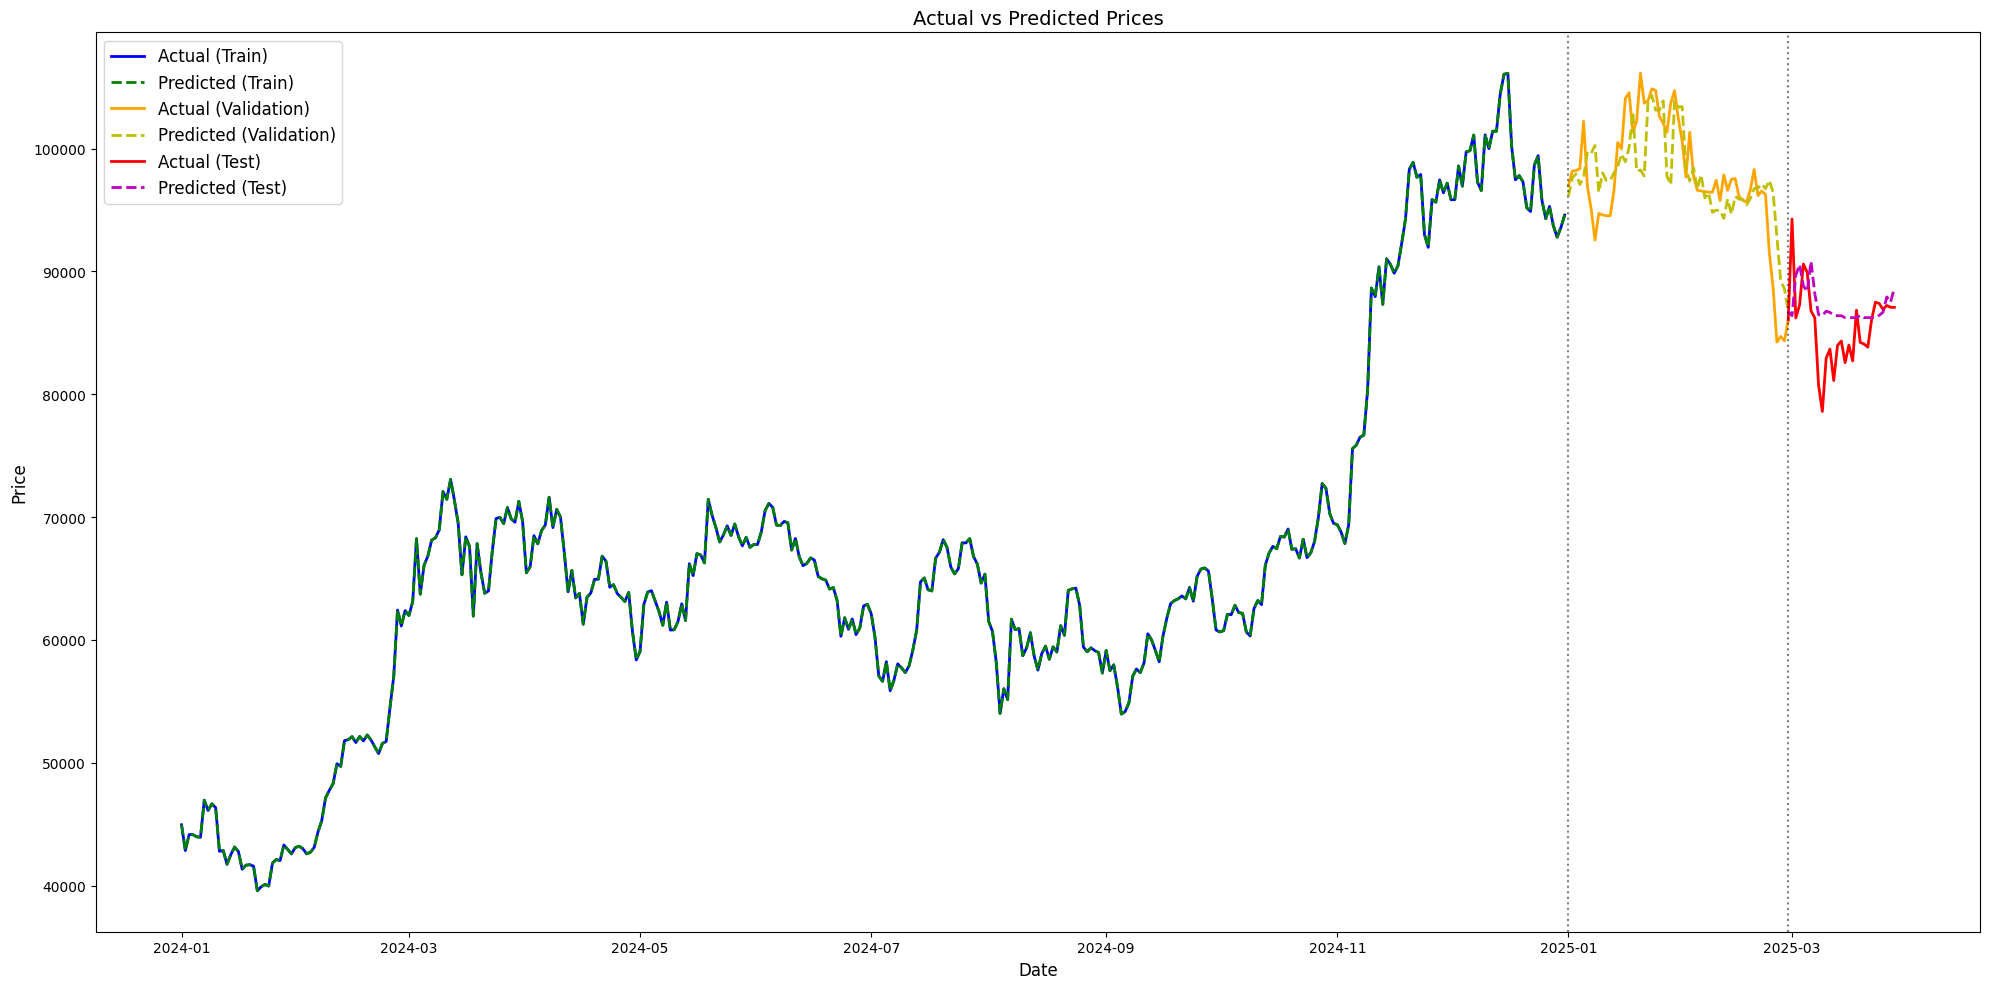

In [401]:
plot_actual_vs_predicted(
    train_prediction_bayes,
    val_prediction_bayes,
    test_prediction_bayes,
    y_train,
    y_val,
    y_test, 
    'close_1_ahead'
)

In [402]:
bayes_xg_boost_2_model, bayes_xg_boost_2_params, train_prediction_bayes, val_rediction_bayes, test_prediction_bayes = bayes_xg_boost('close_2_ahead')



Prediction MSE (gp_minimize): 23930434.512452845


[I 2025-03-28 18:16:45,480] A new study created in memory with name: no-name-6208df5c-a006-4677-8fe0-22f9ebcf9bff


Prediction MSE (BayesSearchCV): 21103026.534967046


[I 2025-03-28 18:16:47,318] Trial 0 finished with value: 241053809.355153 and parameters: {'learning_rate': 0.06629291004536723, 'max_depth': 7, 'gamma': 0.6252491990101152, 'reg_alpha': 3.168243766703395, 'reg_lambda': 6.2941182701044545, 'n_estimators': 185}. Best is trial 0 with value: 241053809.355153.
[I 2025-03-28 18:16:48,290] Trial 1 finished with value: 191347058.2098793 and parameters: {'learning_rate': 0.07643596692562066, 'max_depth': 6, 'gamma': 0.17802213497809946, 'reg_alpha': 2.895428234355156, 'reg_lambda': 0.6680011384657462, 'n_estimators': 168}. Best is trial 1 with value: 191347058.2098793.
[I 2025-03-28 18:16:49,076] Trial 2 finished with value: 217459892.2655697 and parameters: {'learning_rate': 0.06341185467640414, 'max_depth': 6, 'gamma': 0.016255314882294414, 'reg_alpha': 4.327881670831165, 'reg_lambda': 2.7246623328666435, 'n_estimators': 143}. Best is trial 1 with value: 191347058.2098793.
[I 2025-03-28 18:16:50,716] Trial 3 finished with value: 227663157.20

Prediction MSE (Optuna): 23562258.799004093
Best method: BayesSearchCV
Best parameters: OrderedDict([('alpha', 6.4), ('gamma', 0.0), ('lambda_', 3.8585507258942844), ('learning_rate', 0.26443752875031296), ('max_depth', 5), ('n_estimators', 200)])
Train MSE: 10.300321785950254
Validation MSE: 21103026.534967046
Test MSE (Final Model): 19124892.263497595


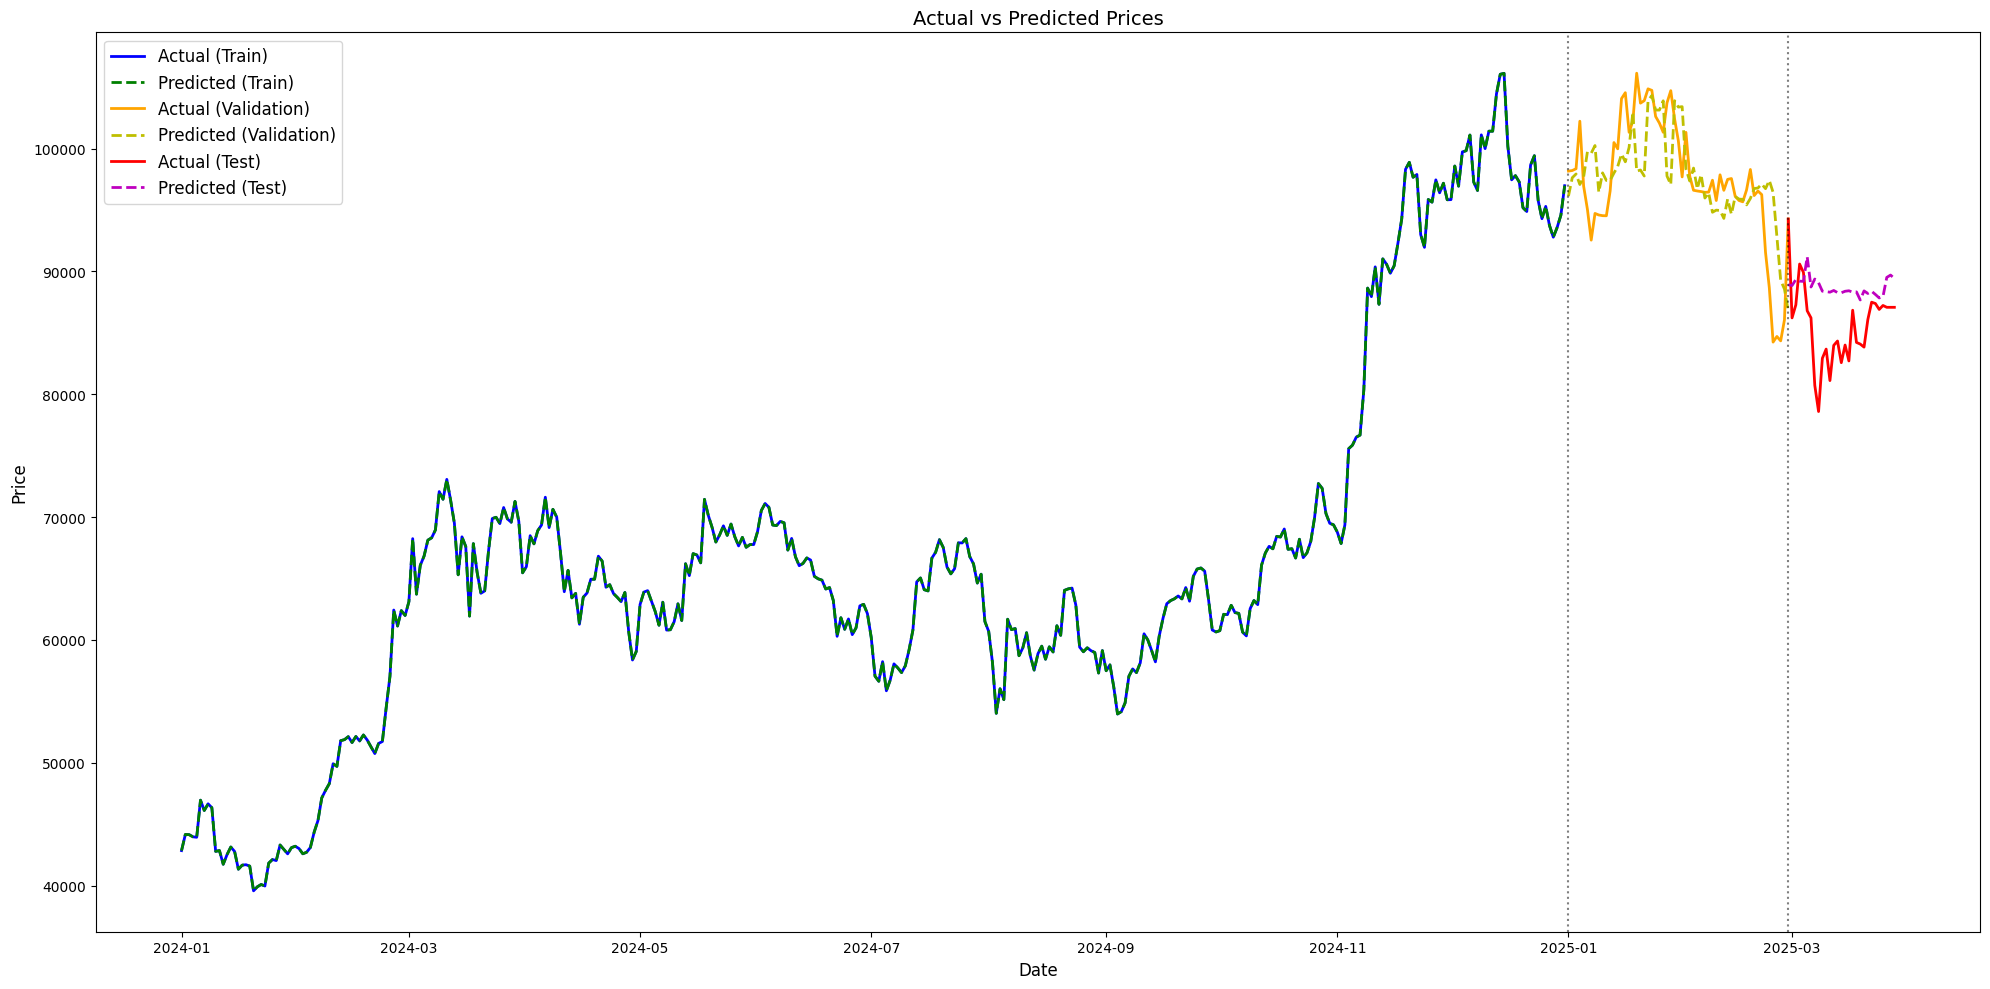

In [403]:
plot_actual_vs_predicted(
    train_prediction_bayes,
    val_prediction_bayes,
    test_prediction_bayes,
    y_train,
    y_val,
    y_test, 
    'close_2_ahead'
)

In [ ]:
bayes_xg_boost_5_model, bayes_xg_boost_5_params, train_prediction_bayes, val_prediction_bayes, test_prediction_bayes = bayes_xg_boost('close_5_ahead')

Prediction MSE (gp_minimize): 28930464.341178592


[I 2025-03-29 01:09:03,401] A new study created in memory with name: no-name-5e7a1d32-11f2-4225-bced-d4e88ed0c6e3


Prediction MSE (BayesSearchCV): 29460690.919751234


[I 2025-03-29 01:09:05,050] Trial 0 finished with value: 253540510.01462176 and parameters: {'learning_rate': 0.06669490382534407, 'max_depth': 6, 'gamma': 0.8168053080870931, 'reg_alpha': 4.4064430155853005, 'reg_lambda': 2.8201028287004637, 'n_estimators': 79}. Best is trial 0 with value: 253540510.01462176.
[I 2025-03-29 01:09:07,724] Trial 1 finished with value: 253370600.84236363 and parameters: {'learning_rate': 0.05239166230605051, 'max_depth': 5, 'gamma': 0.9636142558379514, 'reg_alpha': 0.4925284852133279, 'reg_lambda': 5.807802295491779, 'n_estimators': 138}. Best is trial 1 with value: 253370600.84236363.
[I 2025-03-29 01:09:09,595] Trial 2 finished with value: 263473214.78547838 and parameters: {'learning_rate': 0.07097390112248878, 'max_depth': 6, 'gamma': 0.8462649973154319, 'reg_alpha': 0.7563540817445601, 'reg_lambda': 4.326082028497217, 'n_estimators': 59}. Best is trial 1 with value: 253370600.84236363.
[I 2025-03-29 01:09:11,211] Trial 3 finished with value: 25326990

Prediction MSE (Optuna): 32350170.077205427
Best method: gp_minimize
Best parameters: {'learning_rate': 0.11154825021461114, 'max_depth': 5, 'gamma': 1.347655639351998, 'alpha': 3.0985248002185943, 'lambda': 2.770901416010887}
Train MSE: 122535.33616312695
Validation MSE: 28930464.341178592
Test MSE (Final Model): 49472467.678935684


TypeError: plot_actual_vs_predicted() missing 3 required positional arguments: 'y_val', 'y_test', and 'target_var'

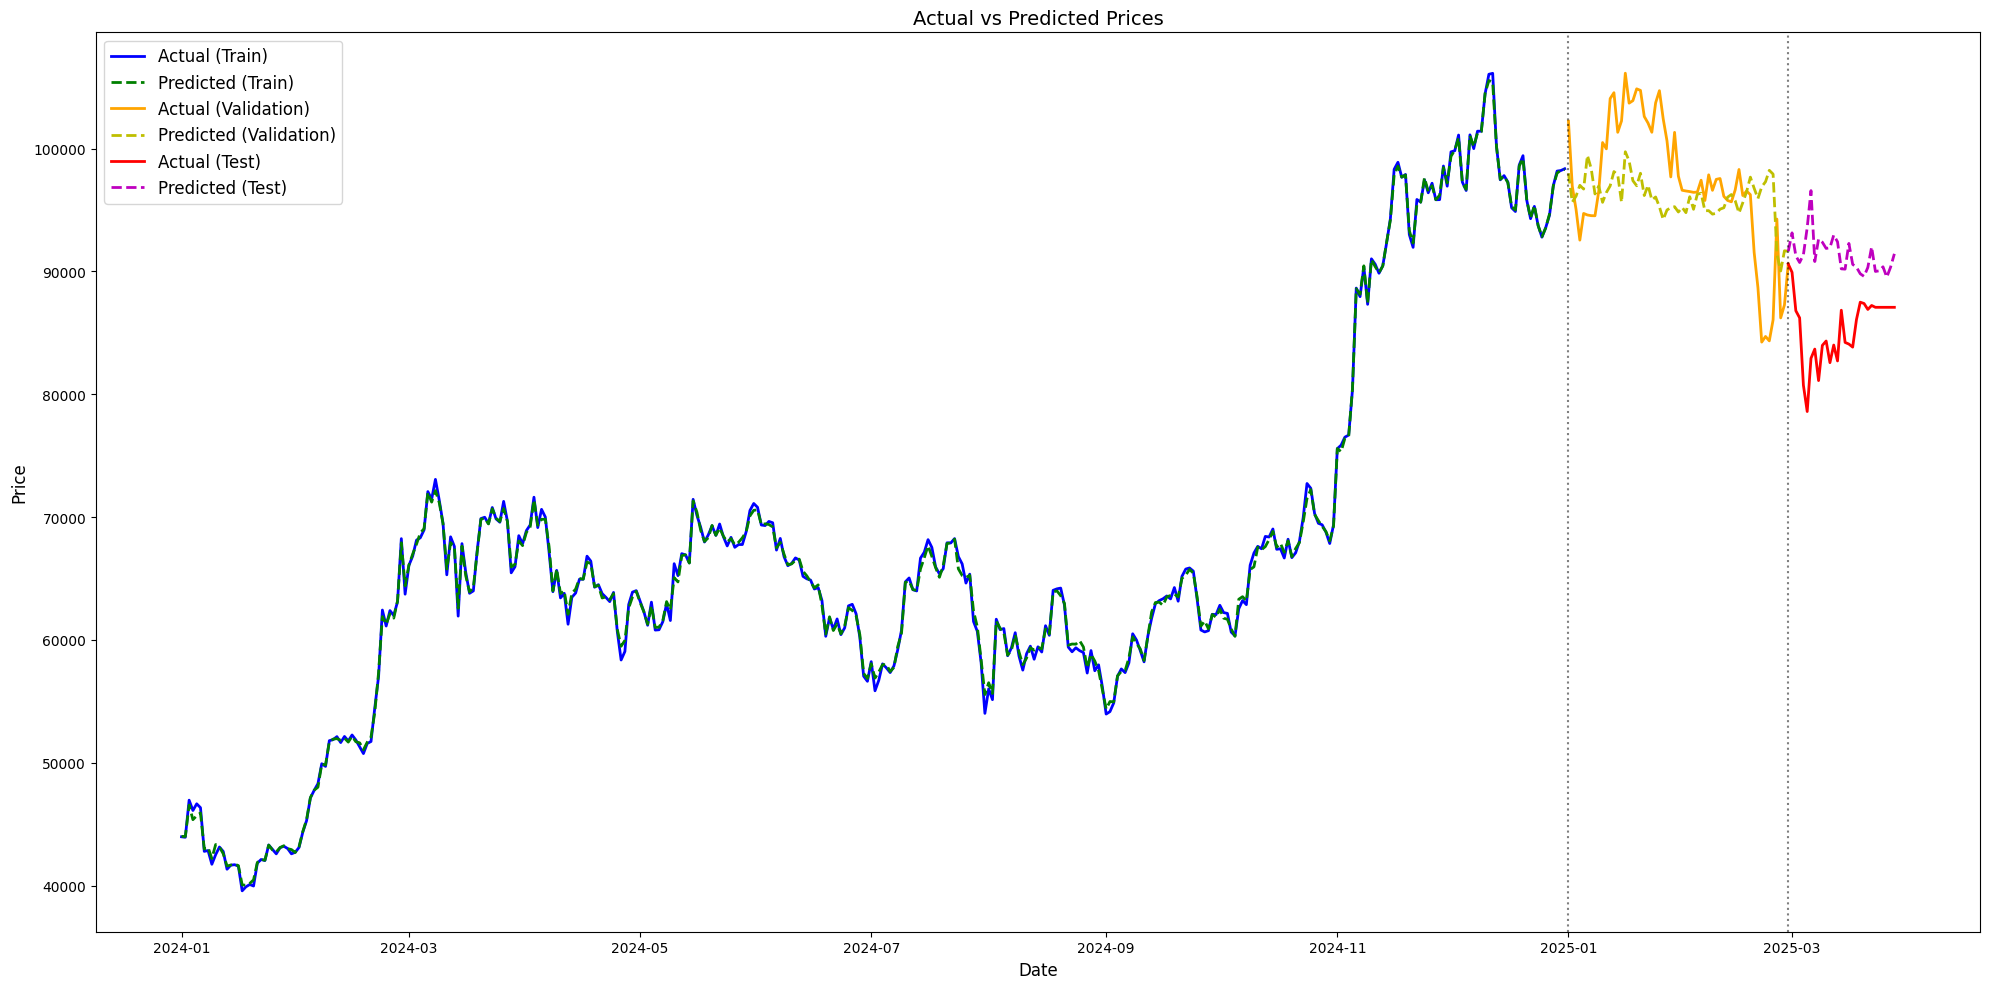

In [453]:
plot_actual_vs_predicted(
    train_prediction_bayes,
    val_prediction_bayes,
    test_prediction_bayes,
    y_train,
    y_val,
    y_test, 
    'close_5_ahead'
)

In [462]:
bayes_xg_boost_10_model, bayes_xg_boost_10_params, train_prediction_bayes, val_prediction_bayes, test_prediction_bayes = bayes_xg_boost('close_10_ahead')


Prediction MSE (gp_minimize): 35082684.26599504


[I 2025-03-29 01:24:27,865] A new study created in memory with name: no-name-08fb7df7-a4ef-4487-984d-4b9fc456598d


Prediction MSE (BayesSearchCV): 40444098.18295644


[I 2025-03-29 01:24:29,146] Trial 0 finished with value: 263424698.6628476 and parameters: {'learning_rate': 0.05206056617869067, 'max_depth': 5, 'gamma': 0.11390237868413032, 'reg_alpha': 6.189876460734466, 'reg_lambda': 1.3324970049712657, 'n_estimators': 168}. Best is trial 0 with value: 263424698.6628476.
[I 2025-03-29 01:24:29,878] Trial 1 finished with value: 260334707.19019362 and parameters: {'learning_rate': 0.05385011646280795, 'max_depth': 5, 'gamma': 0.6370576715084968, 'reg_alpha': 5.53252779456122, 'reg_lambda': 3.5047601906074504, 'n_estimators': 106}. Best is trial 1 with value: 260334707.19019362.
[I 2025-03-29 01:24:31,622] Trial 2 finished with value: 268544176.0380426 and parameters: {'learning_rate': 0.05880336142893439, 'max_depth': 7, 'gamma': 0.046961841196750245, 'reg_alpha': 1.6950735827933356, 'reg_lambda': 0.47555664611523885, 'n_estimators': 116}. Best is trial 1 with value: 260334707.19019362.
[I 2025-03-29 01:24:32,621] Trial 3 finished with value: 257200

Prediction MSE (Optuna): 42166132.58162062
Best method: gp_minimize
Best parameters: {'learning_rate': 0.5391650890419952, 'max_depth': 5, 'gamma': 1.5875384948659486, 'alpha': 4.1048890577663, 'lambda': 4.069918962929687}
Train MSE: 13.220547132015241
Validation MSE: 35082684.26599504
Test MSE (Final Model): 73546483.80656613


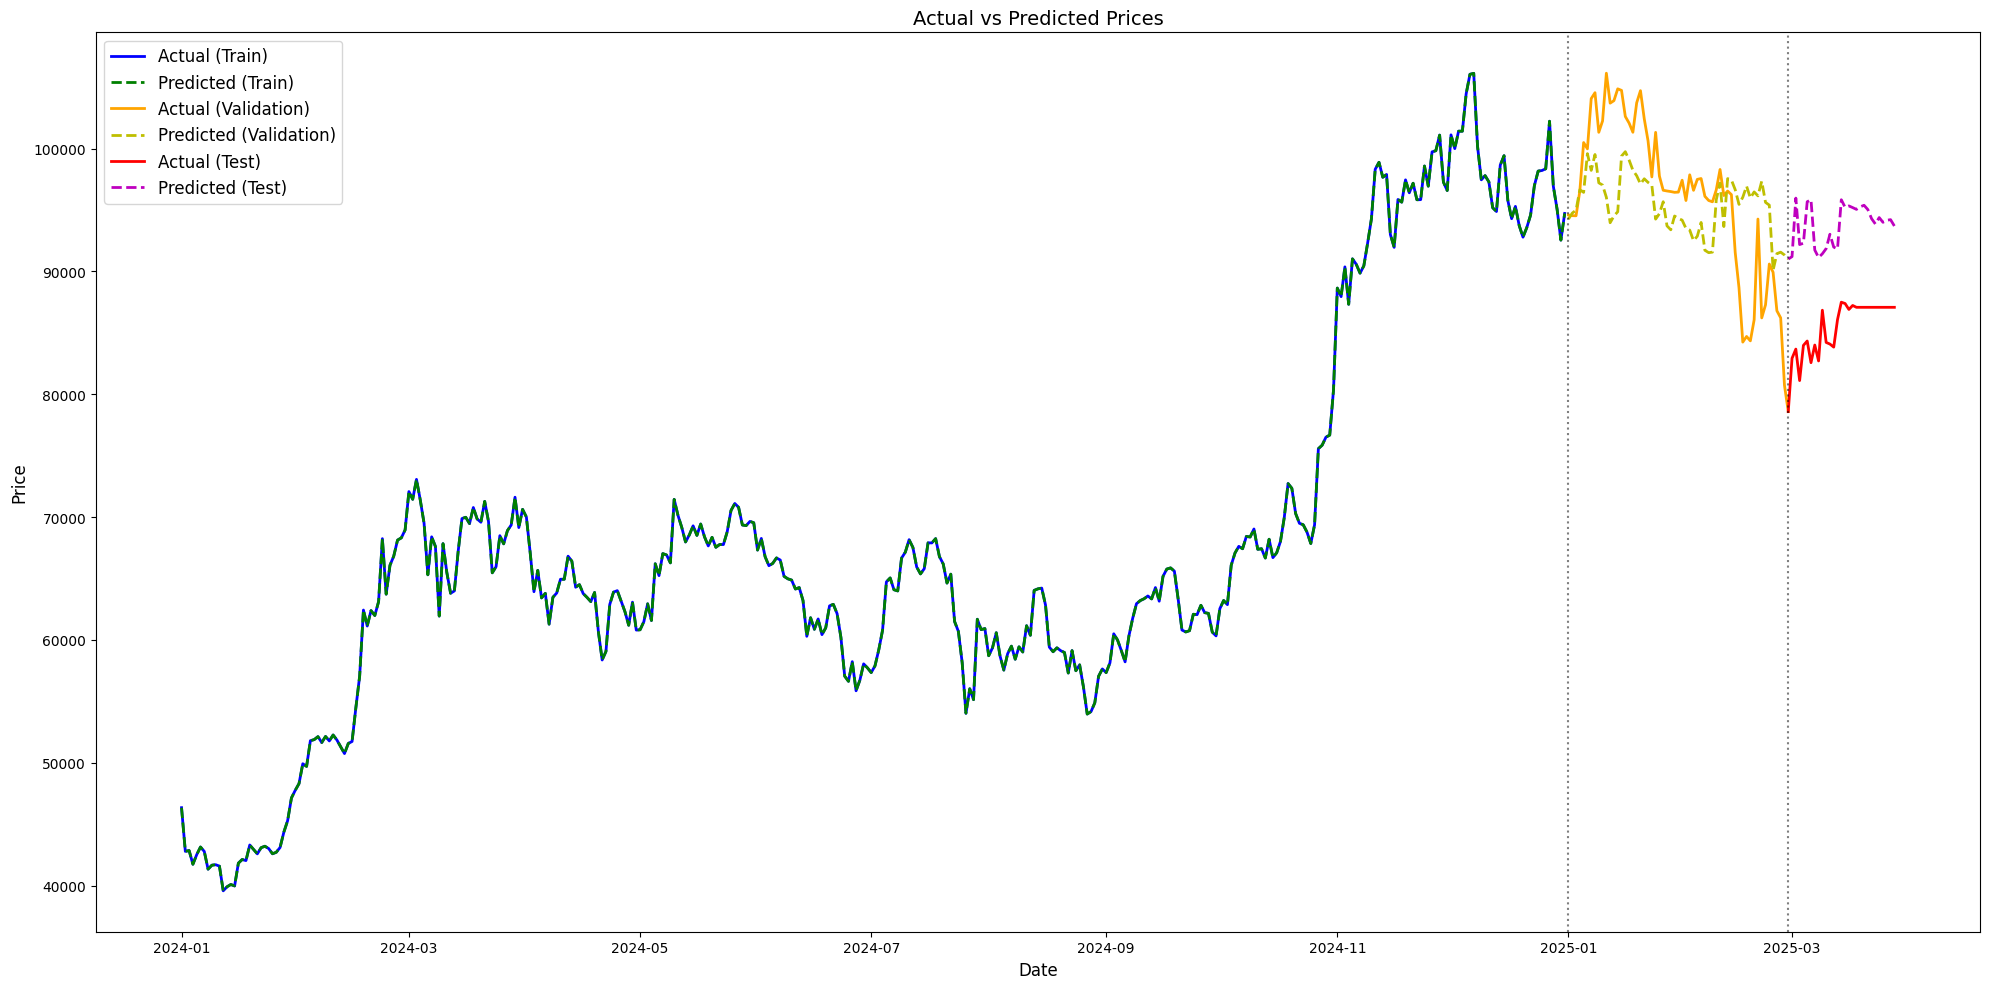

In [467]:
plot_actual_vs_predicted(
    train_prediction_bayes,
    val_prediction_bayes,
    test_prediction_bayes,
    y_train,
    y_val,
    y_test, 
    'close_10_ahead'
)

# Linear Regression Model 

### Hyperparameter tuining using Lasso for feature selection

In [460]:
def train_lasso_model(X_train, X_val, X_test, y_train, y_val, y_test, target_var):

    # Feature selection
    selector = VarianceThreshold(threshold=0.01)
    X_train_reduced = selector.fit_transform(X_train)
    X_val_reduced = selector.transform(X_val)
    X_test_reduced = selector.transform(X_test)
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reduced)
    X_val_scaled = scaler.transform(X_val_reduced)
    X_test_scaled = scaler.transform(X_test_reduced)
    
    # Target values
    y_train_target = y_train[target_var].values.ravel()
    y_val_target = y_val[target_var].values.ravel()
    y_test_target = y_test[target_var].values.ravel()

    # Time series cross-validation for hyperparameter tuning
    tscv = TimeSeriesSplit(n_splits=5)
    alphas = [0.001, 0.01, 0.1, 1, 10]
    
    lasso_grid = GridSearchCV(Lasso(max_iter=10000), param_grid={'alpha': alphas}, cv=tscv)
    lasso_grid.fit(X_train_scaled, y_train_target)

    best_alpha = lasso_grid.best_params_['alpha']
    print("Best alpha:", best_alpha)

    # Train Lasso model with best alpha
    lasso = Lasso(alpha=best_alpha, max_iter=10000, tol=1e-4, warm_start=True)
    lasso.fit(X_train_scaled, y_train_target)
    
    # Predictions
    y_pred_train = lasso.predict(X_train_scaled)
    y_pred_val = lasso.predict(X_val_scaled)
    y_pred_test = lasso.predict(X_test_scaled)
    
    # Scores
    train_score = r2_score(y_train_target, y_pred_train)
    val_score = r2_score(y_val_target, y_pred_val)
    test_score = r2_score(y_test_target, y_pred_test)
    
    print(f'Training R²: {train_score:.4f}')
    print(f'Validation R²: {val_score:.4f}')
    print(f'Test R²: {test_score:.4f}')
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_pred_train, y_pred_val, y_pred_test, lasso


# Running the function
X_train_scaled, X_val_scaled, X_test_scaled, train_pred_lasso, val_pred_lasso, test_pred_lasso, lasso_model = train_lasso_model(
    X_train, X_val, X_test, y_train, y_val, y_test, 'close_1_ahead'
)

print("Train predictions shape:", train_pred_lasso.shape)
print("Validation predictions shape:", val_pred_lasso.shape)
print("Test predictions shape:", test_pred_lasso.shape)


c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.667e+07, tolerance: 2.071e+05

c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e+08, tolerance: 1.475e+06

c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.187e+08, tolerance: 1.865e+06

c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Ob

Best alpha: 10
Training R²: 0.9853
Validation R²: 0.8259
Test R²: 0.0647
Train predictions shape: (366,)
Validation predictions shape: (59,)
Test predictions shape: (29,)


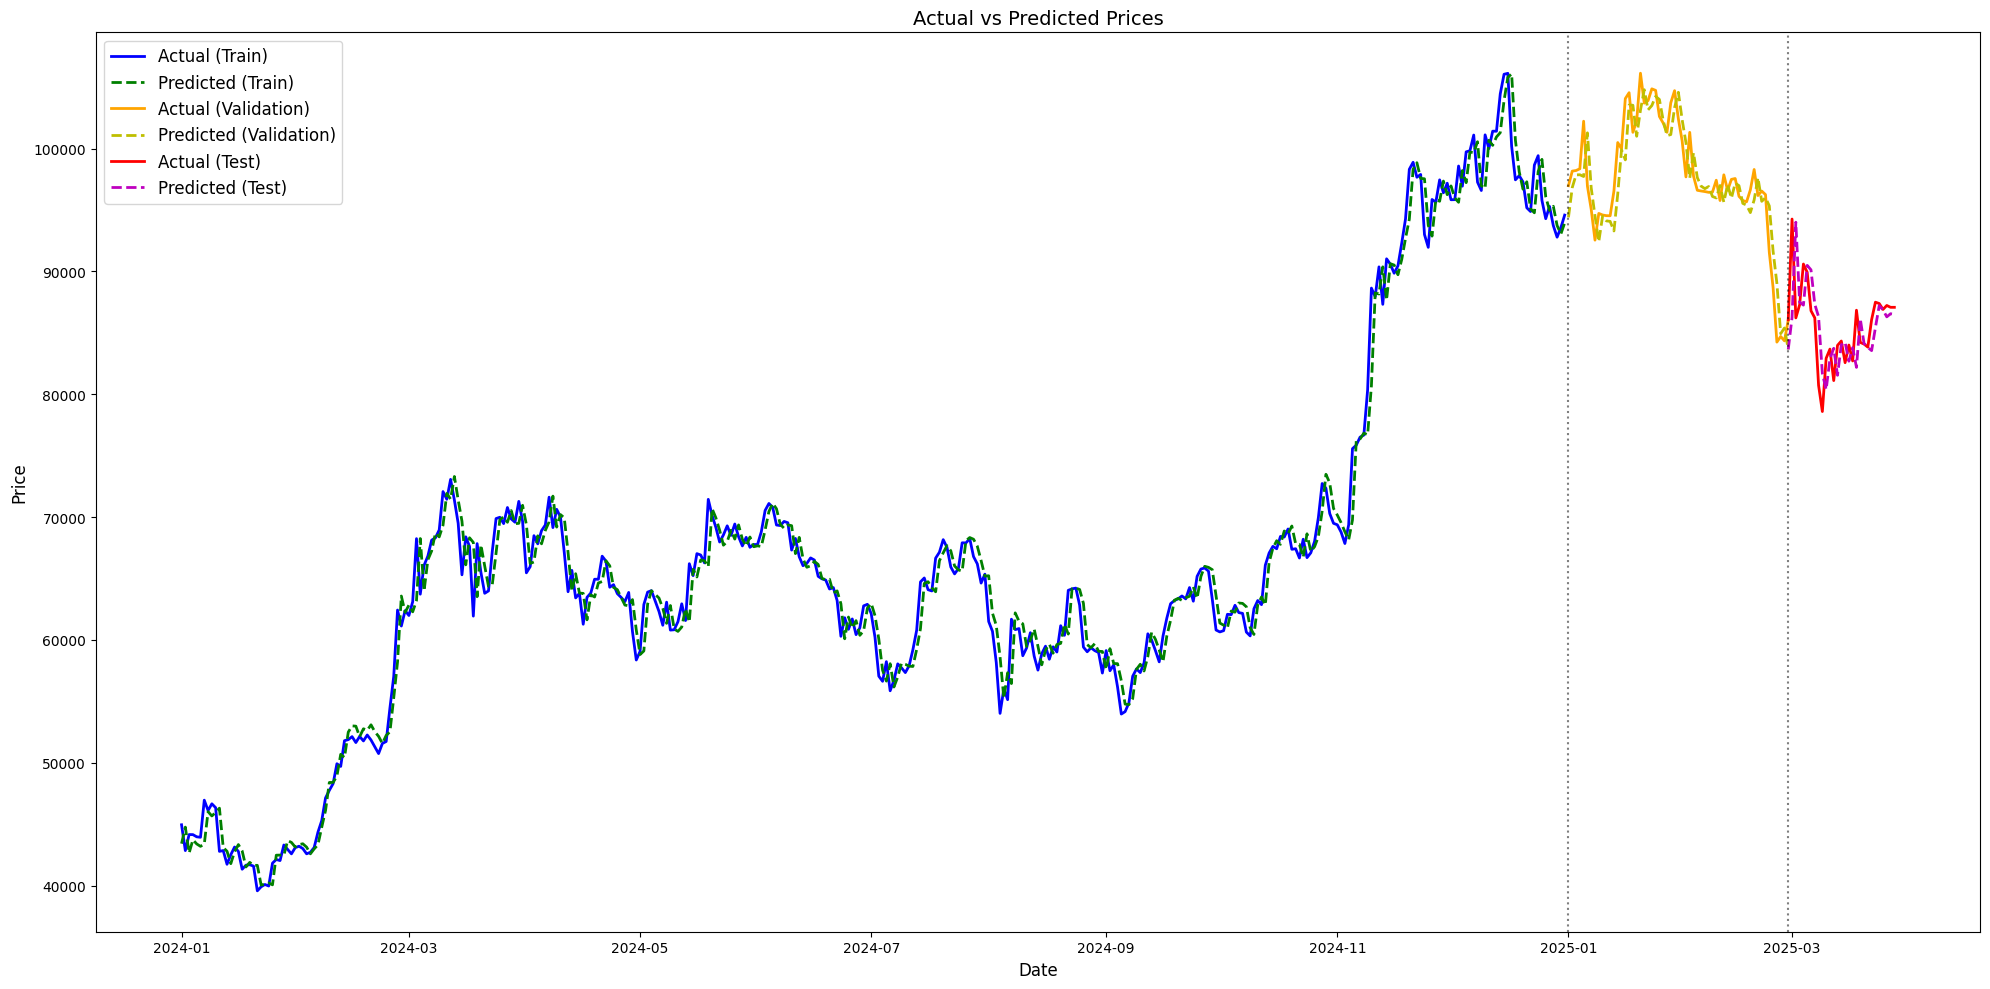

In [461]:
plot_actual_vs_predicted(
    train_pred_lasso, val_pred_lasso, test_pred_lasso,
    y_train,
    y_val,
    y_test, 
    'close_1_ahead'
)

LASSO keeps having error convergin, will try an alternative to L2 regularization - ELASTIC NET which is as such: 
Mix of L1 (sparcity) + l2 (smooth shrinkage), retains more features, handles multicollinearity and more stable convergence, alpha + l1_ratio (L1/L2) mix

In [262]:
def train_elasticnet_model(X_train, X_test, y_train, target_var):
    # Step 1: Scale with RobustScaler
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #filter out highly correlated features
    selector = VarianceThreshold(threshold=0.1)
    X_train_reduced = selector.fit_transform(X_train_scaled)
    X_test_reduced = selector.transform(X_test_scaled)
    
    kept_mask = selector.get_support()
    removed_features = [features[i] for i in np.where(~kept_mask)[0]]
    print("\nRemoved features (low variance):", removed_features)

    #LASSO keeps failing to converge, switch to ealstic net 
    tscv = TimeSeriesSplit(n_splits=5)
    enet_cv = GridSearchCV(
        ElasticNet(warm_start=True),
        param_grid={
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.5, 0.7],  # 0.5 = equal L1/L2, 0.7 = more Lasso-like
            'max_iter': [10_000],
            'tol': [1e-3]
        },
        cv=tscv,
        scoring='neg_mean_squared_error'
    )
    enet_cv.fit(X_train_reduced, y_train[target_var])
    
    print(f'Best params: {enet_cv.best_params_}')
    return enet_cv.best_params_, X_train_reduced, X_test_reduced


best_params_en, X_train_scaled, X_test_scaled = train_elasticnet_model(X_train, X_test, y_train, 'close_1_ahead')



Removed features (low variance): []
Best params: {'alpha': 0.1, 'l1_ratio': 0.5, 'max_iter': 10000, 'tol': 0.001}


In [ ]:
def elasticnet_feature_selection(best_params, X_train_scaled, X_test_scaled, y_train, y_test):
    elasticnet = ElasticNet(**best_params, max_iter = 5000)
    elasticnet.fit(X_train_scaled, X)
    

### Develop Trading Strategy

In [ ]:
# Predict future prices
def predictions(model, col_name):
    train_data[col_name] = model.predict(train_data[features])
    test_data[col_name] = model.predict(test_data[features])




In [48]:
from skopt import gp_minimize

# Define the objective function for weight optimization
def objective(weights):
    # Combine predictions using the weights
    combined_pred = (weights[0] * train_data['Pred_1_day'] +
                     weights[1] * train_data['Pred_2_day'] +
                     weights[2] * train_data['Pred_5_day'] +
                     weights[3] * train_data['Pred_10_day'] +
                     weights[4] * train_data['Pred_20_day'] +
                     weights[5] * train_data['Pred_30_day'])
    
    # Calculate the Sharpe ratio (or any other metric)
    returns = combined_pred.pct_change().dropna()
    sharpe_ratio = returns.mean() / returns.std()
    return -sharpe_ratio  # Minimize the negative Sharpe ratio

# Define the search space for weights
weight_space = [(0, 1) for _ in range(6)]

# Bayesian Optimization for weight optimization
res = gp_minimize(objective, weight_space, n_calls=50, random_state=42)
best_weights = res.x

KeyError: 'Pred_2_day'

## ARIMA

Preprocess Data

In [ ]:
# Create a new DataFrame with a clone of btc_data including the timestamp column
arima_df = btc_data.copy()
def calculate_weighted_averages(data, lags):
    for i in range(1, lags+1):
        
arima_df = btc_data[['close', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'OBV', 'MFI', 'ATR', 'upper_band', 'middle_band', 'lower_band', 'BBW', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'weighted_avg']].copy()
arima_df.reset_index(inplace=True)
print(arima_df.head())

   timestamp     close       SMA       EMA        RSI      MACD  MACD_signal  \
0 2024-03-05  63724.01 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
1 2024-03-06  66074.04 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
2 2024-03-07  66823.17 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
3 2024-03-08  68124.19 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
4 2024-03-09  68313.27 -0.513488 -0.456481  77.822116  0.078483  1008.875495   

    MACD_hist       OBV        MFI  ...    upper_band  middle_band  \
0 -145.010934  0.777210  80.743988  ...  74118.585226   66980.6605   
1 -145.010934  1.141570  80.743988  ...  74118.585226   66980.6605   
2 -145.010934  1.387102  80.743988  ...  74118.585226   66980.6605   
3 -145.010934  1.730745  80.743988  ...  74118.585226   66980.6605   
4 -145.010934  1.822706  80.743988  ...  74118.585226   66980.6605   

     lower_band       BBW     lag_1     lag_2     lag_3     lag_4     lag_5  \
0  59842.735774  0.

In [22]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Assuming 'data' is your DataFrame and 'date' is your timestamp column
arima_df['timestamp'] = pd.to_datetime(arima_df['timestamp'])  # Ensure date column is datetime
arima_df.set_index('timestamp', inplace=True)

# Check for missing values and fill them if needed
arima_df = arima_df.fillna(method='ffill') # Forward fill missing values

# Perform Augmented Dickey-Fuller test for stationarity
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Check stationarity on 'close' price
adf_test(arima_df['close'])


ADF Statistic: -1.3102930665164187
p-value: 0.6244501652162752
The series is non-stationary.


C:\Users\ryant\AppData\Local\Temp\ipykernel_27940\3696961266.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  arima_df = arima_df.fillna(method='ffill') # Forward fill missing values


Difference the df to make it stationary

In [23]:
# First-order differencing to make the series stationary
arima_df['close_diff'] = arima_df['close'] - arima_df['close'].shift(1)

# Perform the ADF test again on the differenced series
adf_test(arima_df['close_diff'].dropna())

ADF Statistic: -20.611240059895128
p-value: 0.0
The series is stationary.


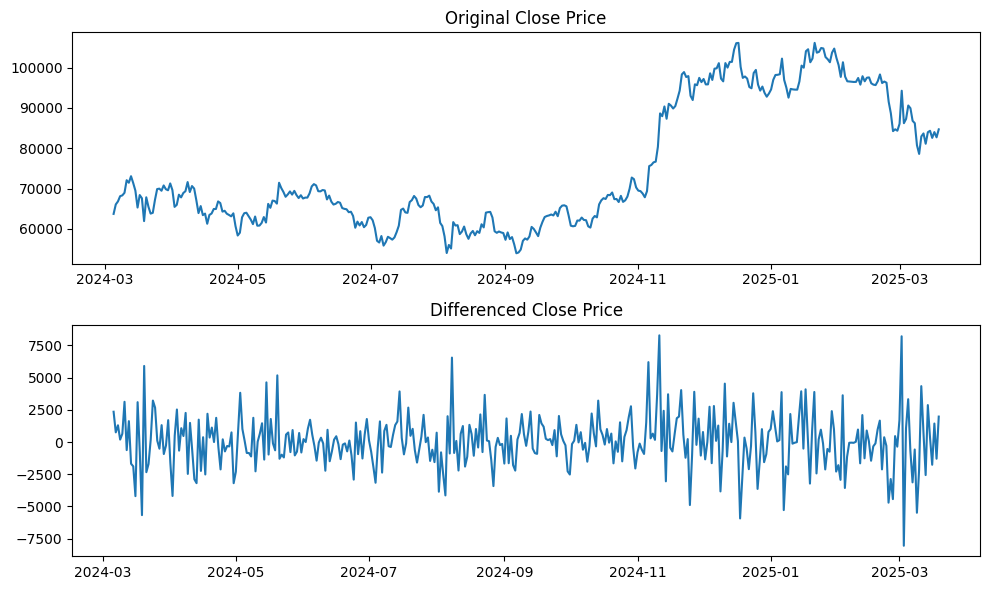

In [24]:
# Plot original data and differenced data
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(arima_df['close'])
plt.title('Original Close Price')

plt.subplot(2, 1, 2)
plt.plot(arima_df['close_diff'])
plt.title('Differenced Close Price')
plt.tight_layout()
plt.show()


In [ ]:
arima_df.reset_index(inplace=True)
# drop index column

print(arima_df.head())

   index  timestamp     close       SMA       EMA        RSI      MACD  \
0      0 2024-03-05  63724.01 -0.513488 -0.456481  77.822116  0.078483   
1      1 2024-03-06  66074.04 -0.513488 -0.456481  77.822116  0.078483   
2      2 2024-03-07  66823.17 -0.513488 -0.456481  77.822116  0.078483   
3      3 2024-03-08  68124.19 -0.513488 -0.456481  77.822116  0.078483   
4      4 2024-03-09  68313.27 -0.513488 -0.456481  77.822116  0.078483   

   MACD_signal   MACD_hist       OBV  ...  middle_band    lower_band  \
0  1008.875495 -145.010934  0.777210  ...   66980.6605  59842.735774   
1  1008.875495 -145.010934  1.141570  ...   66980.6605  59842.735774   
2  1008.875495 -145.010934  1.387102  ...   66980.6605  59842.735774   
3  1008.875495 -145.010934  1.730745  ...   66980.6605  59842.735774   
4  1008.875495 -145.010934  1.822706  ...   66980.6605  59842.735774   

        BBW     lag_1     lag_2     lag_3     lag_4     lag_5  weighted_avg  \
0  0.213134  68245.71  63113.97  61987.28  

In [27]:
arima_df.drop(columns=['index'], inplace=True)
print(arima_df.head())

   timestamp     close       SMA       EMA        RSI      MACD  MACD_signal  \
0 2024-03-05  63724.01 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
1 2024-03-06  66074.04 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
2 2024-03-07  66823.17 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
3 2024-03-08  68124.19 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
4 2024-03-09  68313.27 -0.513488 -0.456481  77.822116  0.078483  1008.875495   

    MACD_hist       OBV        MFI  ...  middle_band    lower_band       BBW  \
0 -145.010934  0.777210  80.743988  ...   66980.6605  59842.735774  0.213134   
1 -145.010934  1.141570  80.743988  ...   66980.6605  59842.735774  0.213134   
2 -145.010934  1.387102  80.743988  ...   66980.6605  59842.735774  0.213134   
3 -145.010934  1.730745  80.743988  ...   66980.6605  59842.735774  0.213134   
4 -145.010934  1.822706  80.743988  ...   66980.6605  59842.735774  0.213134   

      lag_1     lag_2     lag_3     la

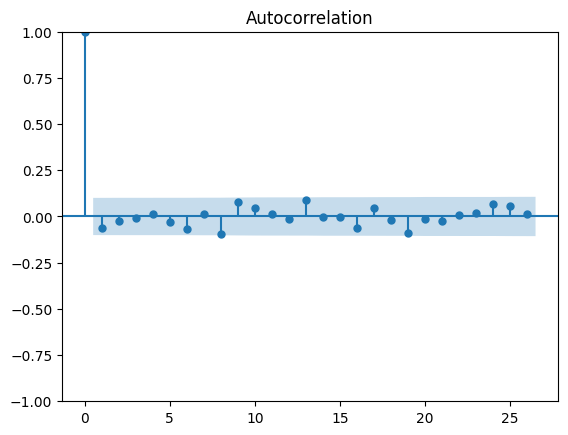

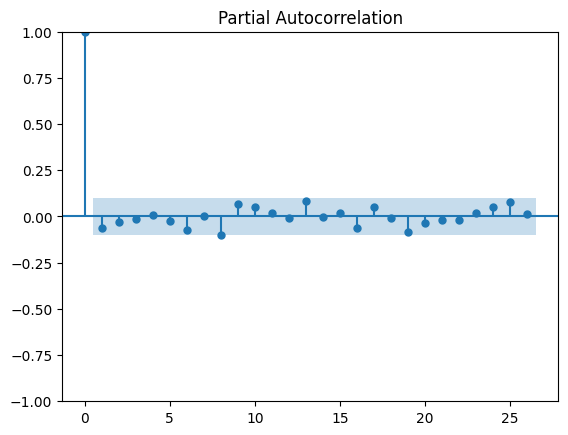

In [28]:
# Plot ACF and PACF for determining p and q
plot_acf(arima_df['close_diff'].dropna())  # ACF plot
plot_pacf(arima_df['close_diff'].dropna())  # PACF plot
plt.show()


In [29]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Fit ARIMA model (p=1, d=1, q=1)
model = ARIMA(arima_df['close'], order=(1, 1, 1))  # (p, d, q)
fitted_model = model.fit()

# Print model summary
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  380
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3426.834
Date:                Thu, 20 Mar 2025   AIC                           6859.668
Time:                        00:31:07   BIC                           6871.480
Sample:                             0   HQIC                          6864.356
                                - 380                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7085      1.311      0.540      0.589      -1.861       3.278
ma.L1         -0.7008      1.320     -0.531      0.595      -3.288       1.886
sigma2      4.184e+06   2.15e+05     19.474      0.0

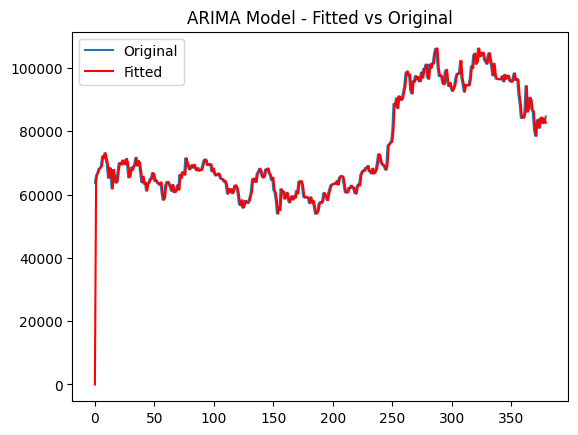

In [30]:
# Plot the forecasted values along with the original series
plt.plot(arima_df['close'], label='Original')
plt.plot(fitted_model.fittedvalues, color='red', label='Fitted')
plt.legend()
plt.title("ARIMA Model - Fitted vs Original")
plt.show()


In [31]:
# Forecast the next 10 periods (e.g., days)
forecast = fitted_model.forecast(steps=10)

# Print the forecasted values
print(forecast)


380    84700.285519
381    84708.217584
382    84713.837480
383    84717.819195
384    84720.640255
385    84722.638985
386    84724.055093
387    84725.058410
388    84725.769264
389    84726.272906
Name: predicted_mean, dtype: float64


### Evaluation

In [ ]:
# Buy & Hold strategy
test_data['Buy_Hold_Returns'] = test_data['Close'].pct_change()
test_data['Cumulative_Buy_Hold_Returns'] = (1 + test_data['Buy_Hold_Returns']).cumprod()

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data['Cumulative_Strategy_Returns'], label='Trading Strategy')
plt.plot(test_data['Cumulative_Buy_Hold_Returns'], label='Buy & Hold')
plt.legend()
plt.show()